# Using Integer Linear Programming for Graph Layout
One difficult problem in data visualization is graph layout. Graph layout techniques have been extensively studied and numerous academic papers have been published on the subject. Some of the popular papers were authored by Sugiyama and Gansner. An old, but still quite popular tool for laying out graphs is GraphViz. A newer tool developed by Kiel University is ELK (Eclipse Layout Kernel). One of the most popular layout techniques for directed graphs is the layered approach. There are several variations but the overall concept is to assign the nodes layers such that as many edges as possible are pointing downstream. After the nodes are assigned layers, their positions within the layer are swapped to minimize edge crossings usually by moving them toward nodes they are connected to. All of these techniques are designed to minimize edge length, edge crossings, and backward edges and total graph area.

Directed graphs in this context means that we have a set of nodes and a set of edges that point from one node source to one node destination. Some of these types of graphs also have node ports that edges connect to. Sometimes the port positions have a fixed position on the node, sometimes the ports are movable or swappable. Some of these types of graphs support hyper edges which are edges with zero or more sources and zero or more destinations(instead of one to one). Usually the preferred edge routing method is orthogonal, where the edges can only travel horizontally or vertically. Some implementations also support bezier curves.

Layered graph layout rely edges to be directed in a particular direction of flow (left to right or top to bottom). While some of the tools (like GraphViz) utilizing these techniques support fixed port positions, when ports are on the wrong side of the flow direction, the graph layout can be very poor. Also, additional structures in the graph such as subgraphs or additional degrees of freedom (port swapping, node rotation) can make the layout algorithms even more complicated to implement.

The layouts produced from the layered approach are usually excellent but there are some domains whose graph properties make them bad candidates for the layered approach. For instance, analog schematics have undirected edges, although there is a convention that power and ground nets are oriented vertically and signal nets are oriented horizontally. Analog schematic symbols can also be rotated.

It is very challenging to write a layout engine that is capable of handling graphs from domains with all of these different properties and capabilities and as the code complexity rises, it becomes more unwieldy to add new features.

This notebook demonstrates how we can simplify layout algorithms by formulating our layout rules mathematically as a set of constraints and a cost function and allowing an off-the-shelf ILP solver to efficiently find the optimal solution. It also demonstrates a graph whose edges are only directed by virtue of which side of the nodes they are connected to.

In this example, we will by using Google's ortools constraint solver, but the process is pretty similar for most solvers.

Finding a solution in this manner is inefficient but simple to implement and maintain.

In [1]:
# python3 built-in
from collections import namedtuple
import xml.etree.ElementTree as ET
from enum import Enum
from dataclasses import dataclass

# 3rd party dependencies
from IPython.display import SVG, display
import z3

Here we define some simple objects to encode our information. We use `Position` both for logical position (grid positioning) as well as visualization position (svg drawing units). We use `Dimension` for widths and heights. We use `Side` for defining which side of the node a port is locked to.

In [2]:
Dimension = namedtuple("Dim", "width height")

@dataclass(frozen=True)
class Position:
    x : int
    y : int
    
    def __add__(self, other):
        return Position(self.x + other.x, self.y + other.y)
    
    def __sub__(self, other):
        return Position(self.x - other.x, self.y - other.y)
    
    def scale(self, margin: Dimension, spacing: Dimension):
        return Position(
            self.x * spacing.width + margin.width,
            self.y * spacing.height + margin.height
        )
    
    def within(self, dom:Dimension):
        if self.x < 0 or self.y < 0:
            return False
        if self.x >= dom.width or self.y >= dom.height:
            return False
        return True
        


# defines which side of a node an edge should connect to
class Side(Enum):
    TOP = 1
    BOTTOM = 2
    LEFT = 3
    RIGHT = 4
    NONE = 5
    
opposites = {Side.TOP:Side.BOTTOM, Side.BOTTOM:Side.TOP, Side.LEFT:Side.RIGHT, Side.NONE:Side.NONE}
rotate = {Side.LEFT:Side.TOP, Side.RIGHT:Side.BOTTOM, Side.NONE:Side.NONE}

Here we define an example data set of a handful of nodes and edges between them. The edges are encoded as directed, but switching source and destination doesn't change the behavior or appearance of the edge.

In [3]:
# node positions must be within the domain
domain = Dimension(6, 3)
# enumerate some nodes
nodes = {
    'A':{'ports':[{'side':Side.RIGHT}]},
    'B':{'ports':[{'side':Side.LEFT },{'side':Side.RIGHT}]},
    'C':{'ports':[{'side':Side.LEFT}]},
    'D':{'ports':[{'side':Side.LEFT}]}
}

# enumerate some edges
edges = [
    {'source_node':'A', 'source_port_index':0, 'dest_node':'B', 'dest_port_index':0},
    {'source_node':'A', 'source_port_index':0, 'dest_node':'C', 'dest_port_index':0},
    {'source_node':'A', 'source_port_index':0, 'dest_node':'D', 'dest_port_index':0}
]

If the input dataset has edges following ports into a cycle, then we can tag edges as "reversed" to break the cycle. This means that for purposes of node position constraints, it is backward, but in all other respects it is normal.

If the input dataset has edges that connect two ports on the same side, then we can tag that edge as "removed". This means that there should be no node position constraints due to this edge. "removed" edges also have a modified cost function.

In [4]:
# TODO: Eliminate Cycles

Here we declare our variables for our solver. You can collapse x and y into a single variable with the domain of width times height, but it's more readable for them to be separate.

We also define a variable for our objective, which in case is the value of our cost function.

In [5]:
solver = z3.Optimize()
# create all variables
for nodeName in nodes.keys():
    x = z3.Int(nodeName+'.x')
    nodes[nodeName]['x'] = x
    solver.add(x >= 0)
    solver.add(x < domain.width)
    y = z3.Int(nodeName+'.y')
    nodes[nodeName]['y'] = y
    solver.add(y >= 0)
    solver.add(y < domain.height)
allvars = [v['x'] for k,v in nodes.items()] + [v['y'] for k,v in nodes.items()]

# define our objective variable
obj_expr = z3.Int('objective')


This constraint is simple. We constrain our solution to ones where no two nodes occupy the same position.

In [6]:
# Constraint 1: no two nodes can occupy the same position
solver.add(z3.Distinct([v['x'] + v['y'] * domain.width for k,v in nodes.items()]))

Here we add two constraints for each side on the edge. The side of the port imposes the direction of the constraint. We also sum up the cost function for each edge. This cost function is a variation of the Manhattan distance that has a higher penalty for long edges. This will push us toward solutions that distribute nodes more equally along long paths.

We also add the sum of all node positions to the objective function to incentivize solutions that are compact to the top left corner

In [7]:
def constrainEdge(fromnode, tonode, side):
    if side == Side.TOP:
        solver.add(fromnode['y'] > tonode['y'])
    elif side == Side.BOTTOM:
        solver.add(fromnode['y'] < tonode['y'])
    elif side == Side.LEFT:
        solver.add(fromnode['x'] > tonode['x'])
    else:
        solver.add(fromnode['x'] < tonode['x'])

def zabs(x):
    return z3.If(x >= 0,x,-x)

# collect the ports and sides for each edge
# and constrain the node positions and
# build up the cost function
edge_costs = []
for e in edges:
    snode = nodes[e['source_node']]
    dnode = nodes[e['dest_node']]
    sside = snode['ports'][e['source_port_index']]['side']
    constrainEdge(snode, dnode, sside)
    dside = dnode['ports'][e['dest_port_index']]['side']
    constrainEdge(dnode, snode, dside)
    edge_costs.append(2 * zabs(snode['x'] - dnode['x']) + 2 * zabs(snode['y'] - dnode['y']))

# finish defining the objectivie function: minimize cost
solver.add(obj_expr == z3.Sum(edge_costs) + z3.Sum([x*x for x in allvars]))
objective = solver.minimize(obj_expr)


Here we collect the best solution the solver can find

In [8]:
solver.check()
solution = solver.model()
best_solution = {str(s):solution[s].as_long() for s in solution}
best_solution

{'D.y': 1,
 'D.x': 1,
 'C.y': 0,
 'C.x': 1,
 'B.y': 0,
 'B.x': 2,
 'A.y': 0,
 'A.x': 0,
 'objective': 17}

In [9]:
# put the solution back into our nodes structure
for node_name, n in nodes.items():
    n['pos'] = Position(best_solution[node_name+'.x'], best_solution[node_name+'.y'])

In [10]:
class SvgNodePortGraph:
    """
    draws nodes and edges to notebook using SVG
    nodes are just names and Positions
    edges are just Positions and Sides
    """
    
    # The spacing between the outermost nodes and the edge of the SVG drawing area
    margin = Dimension(20, 20)
    
    # distance from top-left corner to top-left corner of two nodes
    spacing = Dimension(60, 60)
    
    # node size
    noded = Dimension(30, 30)
    half_noded = Position(15, 15)
    
    text_offset = Position(15, -2)
    
    # size of the svg drawing area
    svg_dims = Dimension(
        width=domain.width * spacing.width + 2 * margin.width,
        height=domain.height * spacing.height + 2 * margin.height)
    
    node_sides = {
        Side.TOP: Position(noded.width/2, 0),
        Side.BOTTOM: Position(noded.width/2, noded.height),
        Side.LEFT: Position(0, noded.height/2),
        Side.RIGHT: Position(noded.width, noded.height/2)
    }
    
    def __init__(self, nodes, edges, grid=False, highlights=[], highlight_color='black'):
        self.svg = ET.Element(
            'svg',
            xmlns="http://www.w3.org/2000/svg",
            version="1.1",
            height="%s" % self.svg_dims.height,
            width="%s" % self.svg_dims.width)
        style = ET.SubElement(self.svg,"style")
        style.text = "rect {fill: gray; stroke: black;} line {stroke: black;}"
        for k,v in nodes.items():
            self.drawbox(k, v['pos'])

        for e in edges:
            self.drawedge(e)
        
        if grid:
            self.drawgrid()
        
        for pos in highlights:
            self.draw_route_region(pos, highlight_color)
    
        self.display()
        
    def drawbox(self, name, pos):
        """adds a new node to the graph"""
        npos = pos.scale(self.margin, self.spacing)
        tpos = npos + self.text_offset
        ET.SubElement(
            self.svg,
            "rect",
            width=str(self.noded.width),
            height=str(self.noded.height),
            x=str(npos.x),
            y=str(npos.y))
        t = ET.SubElement(self.svg, "text", x=str(tpos.x), y=str(tpos.y))
        t.set("text-anchor","middle")
        t.text = name
    
    def draw_route_region(self, pos, color):
        npos = pos.scale(self.margin, self.noded)
        r = ET.SubElement(
            self.svg,
            "rect",
            width=str(self.noded.width),
            height=str(self.noded.height),
            x=str(npos.x),
            y=str(npos.y),
            style='fill:' + color
        )
        r.set('fill-opacity','0.5')
    
    def drawedge(self, e, stroke='black'):
        """ adds a new edge to the graph """
        snode = nodes[e['source_node']]
        sside = snode['ports'][e['source_port_index']]['side']
        source_pos = snode['pos'].scale(self.margin, self.spacing) + self.node_sides[sside]
        dnode = nodes[e['dest_node']]
        dside = dnode['ports'][e['dest_port_index']]['side']
        dest_pos = dnode['pos'].scale(self.margin, self.spacing) + self.node_sides[dside]
        chan_index = 0
        if 'chans' in e:
            chans = e['chans']
        else:
            chans = [0] * 20
        if 'bends' in e:
            prev = source_pos
            print(e['bends'], chans)
            for bend in e['bends']:
                bpos = bend.scale(self.margin, self.noded) + self.half_noded
                if prev.x == bpos.x:
                    scoot = Position(chans[chan_index] * 5, 0)
                else:
                    scoot = Position(0, chans[chan_index] * 5)
                prev = prev + scoot
                bpos = bpos + scoot
                ET.SubElement(
                    self.svg,
                    'line',
                    x1=str(prev.x),
                    y1=str(prev.y),
                    x2=str(bpos.x),
                    y2=str(bpos.y))
                chan_index += 1
                prev = bpos
                source_pos = prev
        if source_pos.x == dest_pos.x:
            scoot = Position(chans[chan_index] * 5, 0)
        else:
            scoot = Position(0,chans[chan_index] * 5)
        source_pos = source_pos + scoot
        dest_pos = dest_pos + scoot
        ET.SubElement(
            self.svg,
            'line',
            x1=str(source_pos.x),
            y1=str(source_pos.y),
            x2=str(dest_pos.x),
            y2=str(dest_pos.y))
        
        
    
    def drawgrid(self):
        for x in range(domain.width * 2):
            start = Position(x, 0).scale(self.margin, self.noded)
            end = Position(x, domain.height * 2).scale(self.margin, self.noded)
            l = ET.SubElement(
                self.svg,
                "line",
                x1=str(start.x),
                y1=str(start.y - self.spacing.height / 4),
                x2=str(end.x),
                y2=str(end.y - self.spacing.height / 4)
            )
            l.set('stroke-dasharray', '4 8')
            
        for y in range(domain.height * 2):
            start = Position(0, y).scale(self.margin, self.noded)
            end = Position(domain.width * 2, y).scale(self.margin, self.noded)
            l = ET.SubElement(
                self.svg,
                "line",
                x1=str(start.x - self.spacing.width / 4),
                y1=str(start.y),
                x2=str(end.x - self.spacing.width / 4),
                y2=str(end.y)
            )
            l.set('stroke-dasharray', '4 8')
            
    
    def display(self):
        """ displays the graph on the notebook """
        display(SVG(ET.tostring(self.svg)))


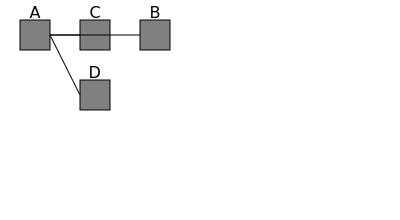

In [11]:
SvgNodePortGraph(nodes, edges)


So at this point the nodes are placed to minimize edge length, but the edges aren't routed orthogonally and even cross in front of nodes. The sugiyama method would involve inserting dummy nodes so that all edges only cross one row, but our graph has two directions of flow, so we will need to determine the best path through the gaps and empty spaces on the grid. Z3 is a very inefficient tools for path-finding so we'll just use A* to route each of our edges.

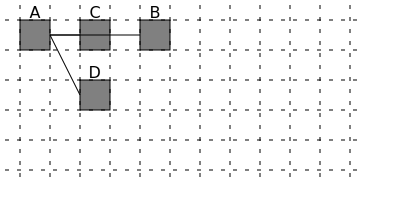

In [12]:
SvgNodePortGraph(nodes, edges, grid=True)

[Position(x=1, y=0), Position(x=1, y=1), Position(x=3, y=1), Position(x=3, y=0)] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Position(x=1, y=0), Position(x=1, y=2)] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


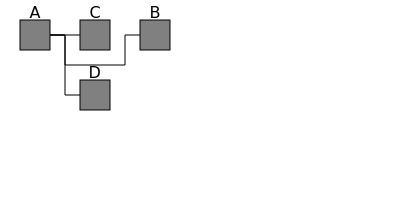

In [13]:
from collections import defaultdict

obstructed = defaultdict(lambda : False)
for n in nodes.values():
    obstructed[n['pos'].scale(Dimension(0,0),Dimension(2,2))] = True

adjustments = {
    Side.TOP: Position(0, -1),
    Side.BOTTOM: Position(0, 1),
    Side.LEFT: Position(-1, 0),
    Side.RIGHT: Position(1, 0)
}

def get_snode_pos(edge):
    return nodes[edge['source_node']]['pos'].scale(Dimension(0,0),Dimension(2,2))

def get_dnode_pos(edge):
    return nodes[edge['dest_node']]['pos'].scale(Dimension(0,0),Dimension(2,2))

def get_source_pos(edge):
    snode = nodes[edge['source_node']]
    sside = snode['ports'][edge['source_port_index']]['side']
    return snode['pos'].scale(Dimension(0,0),Dimension(2,2)) + adjustments[sside]

def get_dest_pos(edge):
    dnode = nodes[edge['dest_node']]
    dside = dnode['ports'][edge['dest_port_index']]['side']
    return dnode['pos'].scale(Dimension(0,0),Dimension(2,2)) + adjustments[dside]

def get_neighbors(pos):
    for v in adjustments.values():
        candidate = pos + v
        if not candidate.within(Dimension(domain.width*2, domain.height*2)):
            continue
        if obstructed[candidate]:
            continue
        yield candidate

def est_cost(source, dest):
    return abs(source.x - dest.x) + abs(source.y - dest.y)

def search_AStar(camefrom, start, end):
    G = {} # movement cost from start to here
    F = {} # estimated movement cost from here to end
    G[start] = 0 
    F[start] = est_cost(start, end)

    closedVertices = set()
    openVertices = set([start])
    cameFrom = {start:camefrom}
    while len(openVertices) > 0:
        #Get the vertex in the open list with the lowest F score
        current = None
        currentFscore = None
        for pos in openVertices:
            if current is None or F[pos] < currentFscore:
                currentFscore = F[pos]
                current = pos
        if current == end:
            path = [current]
            while current != start:
                current = cameFrom[current]
                path.append(current)
            return path

        openVertices.remove(current)
        closedVertices.add(current)
        # Update scores for vertices near the current position
        for neighbour in get_neighbors(current):
            if neighbour in closedVertices: 
                continue # We have already processed this node
            turn = cameFrom[current]-current != current-neighbour
            candidateG = G[current] + 1 if not turn else G[current] + 2
            if neighbour not in openVertices:
                openVertices.add(neighbour) #Discovered a new vertex
            elif candidateG >= G[neighbour]:
                continue # This G score is worse than previously found

            #Adopt this G score
            cameFrom[neighbour] = current
            G[neighbour] = candidateG
            H = est_cost(neighbour, end)
            F[neighbour] = G[neighbour] + H

def get_bends(path):
    prev = path[0]
    for i, p in enumerate(path[1:-1]):
        pnext = path[i+2]
        if p - prev != pnext - p:
            yield p
        prev = p

for e in edges:
    start = get_source_pos(e)
    end = get_dest_pos(e)
    path = [get_dnode_pos(e)] + search_AStar(get_snode_pos(e), start, end) + [get_snode_pos(e)]
    path.reverse()
    e['bends'] = [x for x in get_bends(path)]
SvgNodePortGraph(nodes, edges)

Now our edges are routed orthogonally, but we have unrelated edges on top of each other. So we'll need to push them into separate channels. 

In [14]:
@dataclass
class Segment:
    dir1: Side
    xmin: int
    dir2: Side
    xmax: int
    name: str

def get_dir(p1, p2):
    if p2.y > p1.y:
        return Side.BOTTOM
    if p2.y < p1.y:
        return Side.TOP
    if p2.x > p1.x:
        return Side.RIGHT
    if p2.x < p1.x:
        return Side.LEFT

def get_segments(edge):
    prev = get_snode_pos(edge)
    sside = snode['ports'][e['source_port_index']]['side']
    for bend in edge['bends']:
        yield prev, bend, get_dir(prev, bend)
        prev = bend
    dpos = get_dnode_pos(edge)
    yield prev, dpos, get_dir(prev, dpos)

segs_by_row = defaultdict(list)
segs_by_col = defaultdict(list)
for edge in edges:
    n = edge['source_node'] + '.'+str(edge['source_port_index']) +'=>'+edge['dest_node'] + '.'+str(edge['dest_port_index'])
    segs = [x for x in get_segments(edge)]
    for i, seg in enumerate(segs):
        p1, p2, d = seg
        prev_d = segs[i-1][2] if i>0 else Side.NONE
        next_d = segs[i+1][2] if i+1<len(segs) else Side.NONE
        if d == Side.RIGHT:
            xmin = p1.x
            xmax = p2.x
            if i > 0:
                d1 = opposites[prev_d]
            else:
                d1 = Side.NONE
            if seg is not segs[-1]:
                d2 = next_d
            else:
                d2 = Side.NONE
            segs_by_row[p1.y].append(Segment(d1, xmin, d2, xmax, n+'['+str(i)+']'))
        if d == Side.LEFT:
            xmin = p2.x
            xmax = p1.x
            if i > 0:
                d2 = opposites[prev_d]
            else:
                d2 = Side.NONE
            if seg is not segs[-1]:
                d1 = next_d
            else:
                d1 = Side.NONE
            segs_by_row[p1.y].append(Segment(d1, xmin, d2, xmax, n+'['+str(i)+']'))
        if d == Side.TOP:
            xmin = p2.y
            xmax = p1.y
            if i>0:
                d1 = opposites[rotate[prev_d]]
            else:
                d1 = Side.NONE
            if seg is not segs[-1]:
                d2 = rotate[next_d]
            else:
                d2 = Side.NONE
            segs_by_col[p1.x].append(Segment(d1, xmin, d2, xmax, n+'['+str(i)+']'))
        if d == Side.BOTTOM:
            xmin = p1.y
            xmax = p2.y
            if i>0:
                d2 = opposites[rotate[prev_d]]
            else:
                d2 = Side.NONE
            if seg is not segs[-1]:
                d1 = rotate[next_d]
            else:
                d1 = Side.NONE
            segs_by_col[p1.x].append(Segment(d1, xmin, d2, xmax, n+'['+str(i)+']'))
all_chans = []
solver = z3.Optimize()
crossings = z3.Int('crossings')
cross_conds = []
for row, segs in segs_by_row.items():
    for seg in segs:
        seg.chan = z3.Int(seg.name+'.chan')
        solver.add(seg.chan > -1)
        all_chans.append(seg.chan)
    for s in segs:
        for s2 in segs:
            if s is s2:
                continue
            if s.xmin >= s2.xmin and s.xmin <= s2.xmax:
                solver.add(z3.Distinct(s.chan, s2.chan))
                if s.dir1 == Side.TOP:
                    cross_conds.append(z3.If(s.chan > s2.chan, 1, 0))
                elif s.dir1 == Side.BOTTOM:
                    cross_conds.append(z3.If(s.chan < s2.chan, 1, 0))
            # s.xmax overlaps with s2
            if s.xmax >= s2.xmin and s.xmax <= s2.xmax:
                solver.add(z3.Distinct(s.chan, s2.chan))
                if s.dir2 == Side.TOP:
                    cross_conds.append(z3.If(s.chan > s2.chan, 1, 0))
                elif s.dir2 == Side.BOTTOM:
                    cross_conds.append(z3.If(s.chan < s2.chan, 1, 0))
for col, segs in segs_by_col.items():
    for seg in segs:
        seg.chan = z3.Int(seg.name+'.chan')
        solver.add(seg.chan > -1)
        all_chans.append(seg.chan)
    for s in segs:
        for s2 in segs:
            if s is s2:
                continue
            if s.xmin >= s2.xmin and s.xmin <= s2.xmax:
                solver.add(z3.Distinct(s.chan, s2.chan))
                if s.dir1 == Side.TOP:
                    cross_conds.append(z3.If(s.chan > s2.chan, 1, 0))
                elif s.dir1 == Side.BOTTOM:
                    cross_conds.append(z3.If(s.chan < s2.chan, 1, 0))
            # s.xmax overlaps with s2
            if s.xmax >= s2.xmin and s.xmax <= s2.xmax:
                solver.add(z3.Distinct(s.chan, s2.chan))
                if s.dir2 == Side.TOP:
                    cross_conds.append(z3.If(s.chan > s2.chan, 1, 0))
                elif s.dir2 == Side.BOTTOM:
                    cross_conds.append(z3.If(s.chan < s2.chan, 1, 0))
solver.minimize(z3.Sum(cross_conds) + z3.Sum(all_chans))

solver.check()
solution = solver.model()
best_solution = {str(s):solution[s].as_long() for s in solution}
best_solution
for edge in edges:
    n = edge['source_node'] + '.'+str(edge['source_port_index']) +'=>'+edge['dest_node'] + '.'+str(edge['dest_port_index'])
    chans = sorted([(k,v) for k, v in best_solution.items() if k.startswith(n)])
    chans = [x[1] for x in chans]
    edge['chans'] = chans
best_solution

{'A.0=>B.0[3].chan': 0,
 'A.0=>D.0[1].chan': 1,
 'A.0=>D.0[0].chan': 1,
 'A.0=>B.0[0].chan': 2,
 'A.0=>C.0[0].chan': 0,
 'A.0=>B.0[1].chan': 0,
 'A.0=>D.0[2].chan': 0,
 'A.0=>B.0[4].chan': 0,
 'A.0=>B.0[2].chan': 0}

[Position(x=1, y=0), Position(x=1, y=1), Position(x=3, y=1), Position(x=3, y=0)] [2, 0, 0, 0, 0]
[] [0]
[Position(x=1, y=0), Position(x=1, y=2)] [1, 1, 0]


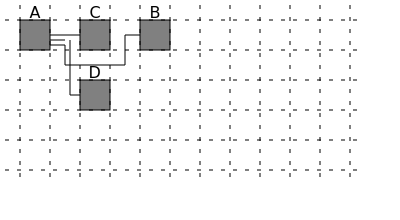

[Position(x=1, y=0), Position(x=1, y=1), Position(x=3, y=1), Position(x=3, y=0)] [2, 0, 0, 0, 0]
[] [0]
[Position(x=1, y=0), Position(x=1, y=2)] [1, 1, 0]


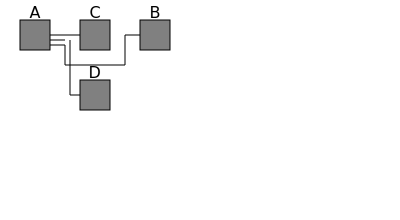

In [15]:
SvgNodePortGraph(nodes, edges, grid=True)
SvgNodePortGraph(nodes, edges)